In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import anndata as ad
import pandas as pd
import os
from scipy.sparse import csr_matrix

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

In [2]:
YU_adata=ad.read("/data/newdata/deconv/anno_test/GSE117891_Yu_2020/GSE117891_all_6148_fs.h5ad")
YU_delet_samples=["S15","S14","S9","S8","S7","S4"]
YU_adata=YU_adata[~(YU_adata.obs.Patients.isin(YU_delet_samples))].copy()
infercnv_kmeans_types=pd.read_csv("/data/newdata/deconv/anno_test/GSE117891_Yu_2020/kmeans_df_s_k7.txt",sep='\t',index_col=0)
tmp=pd.merge(YU_adata.obs,infercnv_kmeans_types,how='left',left_index=True,right_index=True)
YU_adata.obs["mag_nonmag"]=tmp["mag_nonmag"]
YU_adata.obs['batch']='YU'
YU_adata.obs['TumorID']="YU"+YU_adata.obs['Patients'].astype("str")
YU_adata.obs['orin_index']=YU_adata.obs.index
YU_adata.obs.index=YU_adata.obs["batch"].astype("str")+'_'+YU_adata.obs["Patients"].astype("str")+'_'+pd.Series(range(1,len(YU_adata.obs.index)+1),index=YU_adata.obs.index).astype('str')

In [3]:
YU_adata[YU_adata.obs["TumorID"]=="YUS13"].obs["Types"].value_counts()

Tumoral        866
Peritumoral    112
Name: Types, dtype: int64

In [4]:
YU_adata[YU_adata.obs["TumorID"]=="YUS13"].obs.groupby(["Samples","Types"],as_index=False).count()

,Samples,Types,Points,Patients,n_genes,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,...,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,scDblFinder_score,scDblFinder_class,size_factors,mag_nonmag,batch,TumorID,orin_index
0,S13P1,Peritumoral,23,23,23,23,23,23,23,23,...,23,23,23,23,23,23,23,23,23,23
1,S13P1,Tumoral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,S13P2,Peritumoral,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
3,S13P2,Tumoral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,S13P4,Peritumoral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,S13P4,Tumoral,344,344,344,344,344,344,344,344,...,344,344,344,344,344,344,344,344,344,344
6,S13P5,Peritumoral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,S13P5,Tumoral,341,341,341,341,341,341,341,341,...,341,341,341,341,341,341,341,341,341,341
8,S13P6,Peritumoral,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,S13P6,Tumoral,181,181,181,181,181,181,181,181,...,181,181,181,181,181,181,181,181,181,181


In [5]:
YU_adata.obs["TumorID"].value_counts()

YUS11    1010
YUS13     978
YUS12     633
YUS1      377
YUS6      355
YUS5      326
YUS2      258
YUS3      256
Name: TumorID, dtype: int64

## quality control

In [39]:
# mitochondrial genes
YU_adata.var["mt"] = YU_adata.var_names.str.startswith("MT-")
# ribosomal genes
YU_adata.var["ribo"] = YU_adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
YU_adata.var["hb"] = YU_adata.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    YU_adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
YU_adata

AnnData object with n_obs × n_vars = 4193 × 22947
    obs: 'Points', 'Types', 'Patients', 'Samples', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'size_factors', 'mag_nonmag', 'batch', 'TumorID', 'orin_index'
    var: 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant', 'binomial_deviance'
    uns: 'Patients_colors', 'Types_colors', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'analytic_pearson_residuals_pca', 'log1p_norm_pca', 'scran_normalization_pca'
    varm: 'PCs'
    layers: 'analytic_pearson_residuals', 'log1p_norm', 's

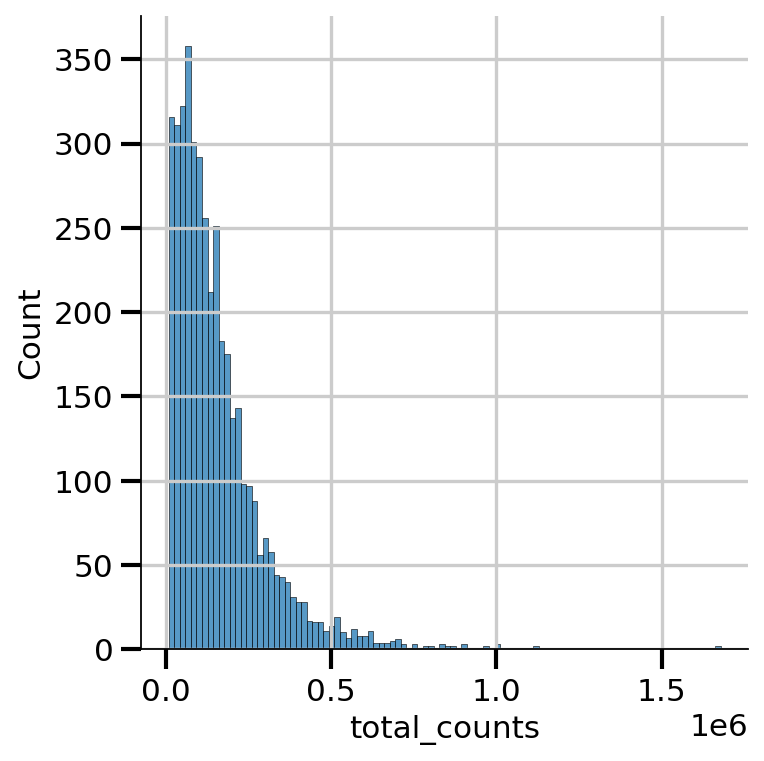

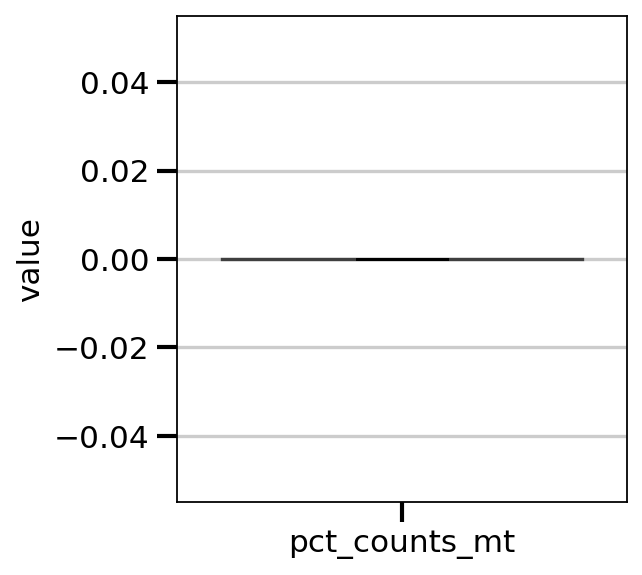

In [67]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('QC_plots.pdf') as pdf:
    p1 = sns.displot(YU_adata.obs["total_counts"], bins=100, kde=False)
    pdf.savefig()
    # sc.pl.violin(adata, 'total_counts')
    p2 = sc.pl.violin(YU_adata, "pct_counts_mt",show=False)
    pdf.savefig()
    p3 = sc.pl.scatter(YU_adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",show=False)
    pdf.savefig()
    plt.close()

In [42]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [46]:
YU_adata.obs["outlier"] = (
    is_outlier(YU_adata, "log1p_total_counts", 5)
    | is_outlier(YU_adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(YU_adata, "pct_counts_in_top_20_genes", 5)
)
YU_adata.obs.outlier.value_counts()

False    4150
True       43
Name: outlier, dtype: int64

In [47]:
YU_adata.obs["mt_outlier"] = is_outlier(YU_adata, "pct_counts_mt", 3) | (
    YU_adata.obs["pct_counts_mt"] > 8
)
YU_adata.obs.mt_outlier.value_counts()

False    4193
Name: mt_outlier, dtype: int64

In [63]:
print(f"Total number of cells: {YU_adata.n_obs}")
YU_adata = YU_adata[(~YU_adata.obs.outlier) & (~YU_adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {YU_adata.n_obs}")

Total number of cells: 4193
Number of cells after filtering of low quality cells: 4150


In [77]:
YU_adata.write("GSE117891_4150_quality_control.h5ad")

## Doublet Detection

In [1]:
# Python packages
import scanpy as sc
import scvi
import bbknn
import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
import anndata2ri
import logging

import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is depr

In [7]:
%%R
library(SoupX)

In [2]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Attaching SeuratObject
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedi

In [5]:
YU_adata=ad.read("GSE117891_4150_quality_control.h5ad")

In [6]:
data_mat = YU_adata.X.T

In [7]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

/home/zhouying/miniconda3/envs/scRNAseq/lib/python3.11/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Creating ~5000 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 453 cells excluded from training.
iter=1, 513 cells excluded from training.
iter=2, 535 cells excluded from training.
Threshold found:0.7
327 (7.9%) doublets called


In [9]:
YU_adata.obs["scDblFinder_score"] = doublet_score
YU_adata.obs["scDblFinder_class"] = doublet_class
YU_adata.obs.scDblFinder_class.value_counts()

singlet    3823
doublet     327
Name: scDblFinder_class, dtype: int64

In [50]:
YU_adata.write("GSE117891_4150_mark_singlet.h5ad")
YU_del_doublet.write("GSE117891_3823_singlet_final.h5ad")

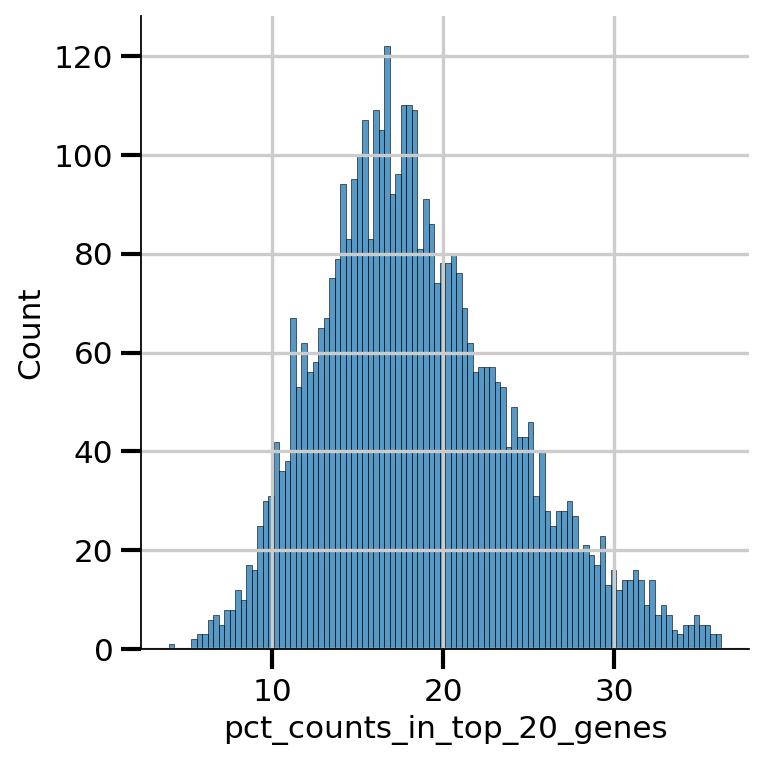

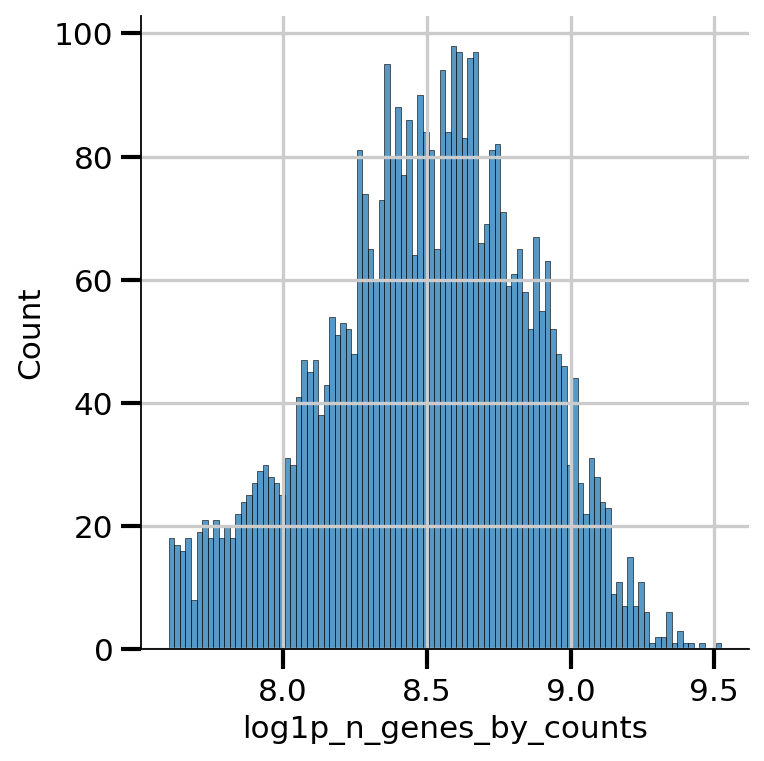

In [71]:
sns.displot(YU_adata.obs["pct_counts_in_top_20_genes"], bins=100, kde=False)
sns.displot(YU_adata[YU_adata.obs.outlier!="Ture"].obs["log1p_n_genes_by_counts"], bins=100, kde=False)

## scRNA-seq preprocessing function

In [61]:
def preprocessing(adata,Sample_key,save_path,batch_key=None,batch_name=None):
    '''running all datasets by this process to filter low-quality cells and doublets
    refer to https://www.sc-best-practices.org/preprocessing_visualiza
    quality control performed on following three covariates:
    1. The number of counts per barcode (count depth)
    2. The number of genes per barconde
    3. The franction of counts from mitochondrial genes per barcode
    Using MAD (median absolute deviations) as threshold to filter all metrics
    MAD=median(|Xi-median(X)|), Xi is the respective QC metric of an observation
    cells are maked as outliers out of 5 MADs [Germain et al., 2020](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)'''
    import numpy as np
    import scanpy as sc
    import seaborn as sns
    from scipy.stats import median_abs_deviation
    import anndata as ad
    import pandas as pd
    import os
    from scipy.sparse import csr_matrix
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages
    
    sc.settings.verbosity = 0
    sc.settings.set_figure_params(
        dpi=80,
        facecolor="white",
        frameon=False,
    )
    
    stats=pd.DataFrame(data=list(adata.obs[Sample_key].value_counts()),
             columns=["N.cells in RawData"],
             index=list(adata.obs[Sample_key].value_counts().index))
    # mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    # ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    # hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)

    if batch_name is not None:
        QC_plot_savepath=save_path+batch_name+"_qc_plot.pdf"
    elif batch_key is not None:
        QC_plot_savepath=save_path+adata.obs[batch_key].unique()[0]+"_qc_plot.pdf"
    else:
        print("Please give \"batch_name\" or \"batch_key\" ")
        
    with PdfPages(QC_plot_savepath) as pdf:
        p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
        pdf.savefig()
        # sc.pl.violin(adata, 'total_counts')
        p2 = sc.pl.violin(adata, "pct_counts_mt",show=False)
        pdf.savefig()
        p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",show=False)
        pdf.savefig()
        plt.close()
    
    def is_outlier(adata, metric: str, nmads: int):
        M = adata.obs[metric]
        outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
            np.median(M) + nmads * median_abs_deviation(M) < M
        )
        return outlier

    # log1p_total_counts, log1p_n_genes_by_counts and pct_counts_in_top_20_genes QC covariates each with a threshold of 5 MADs
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )

    # pct_counts_Mt is filtered with 3 MADs. Additionally, cells with a percentage of mitochondrial counts exceeding 8 % are filtered out.
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )
    
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    stats["N.cells passing QC"]=adata.obs[Sample_key].value_counts()
    
    # Doublet Detection using scDblFinder R package
    import anndata2ri
    import logging
    
    import rpy2.rinterface_lib.callbacks as rcb
    import rpy2.robjects as ro
    
    rcb.logger.setLevel(logging.ERROR)
    ro.pandas2ri.activate()
    anndata2ri.activate()
    
    Rcode="""
    doublet <- function(mat){
    library(Seurat)
    library(scater)
    library(scDblFinder)
    library(BiocParallel)
    set.seed(123)
    sce = scDblFinder(
    SingleCellExperiment(
        list(counts=mat),
        ) 
    )
    doublet_score = sce$scDblFinder.score
    doublet_class = sce$scDblFinder.class
    ans=list("score"=doublet_score,"class"=doublet_class)
    return(ans)
    }
    """
    ro.r(Rcode)

    data_mat = adata.X.T
    ans=ro.r['doublet'](data_mat)
    
    adata.obs["scDblFinder_score"] = ans['score']
    adata.obs["scDblFinder_class"] = ans['class']
    adata.obs.scDblFinder_class.value_counts()

    adata=adata[adata.obs.scDblFinder_class=="singlet"]
    stats["N.singlet cells"]=adata.obs[Sample_key].value_counts()

    if batch_name is not None:
        adata.write(save_path+batch_name+"_qc.h5ad")
        stats.to_csv(save_path+batch_name+"_stats.csv")
    elif batch_key is not None:
        adata.write(save_path+adata.obs[batch_key].unique()[0]+"_qc.h5ad")
        stats.to_csv(save_path+adata.obs[batch_key].unique()[0]+"_stats.csv")
    else:
        print("Please give \"batch_name\" or \"batch_key\" ")

Total number of cells: 4193
Number of cells after filtering of low quality cells: 4150

    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

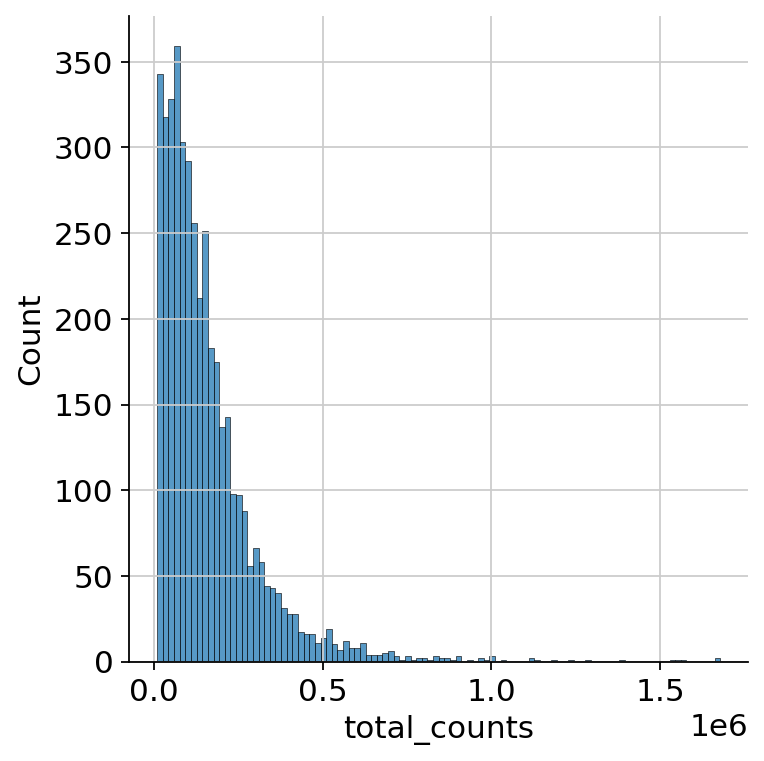

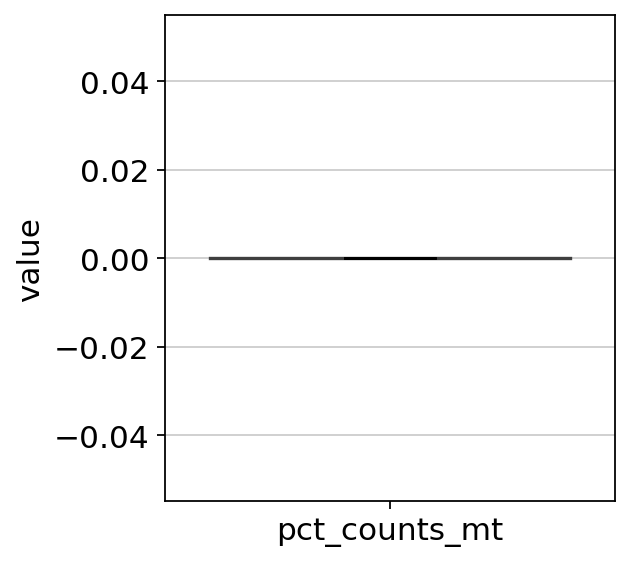

In [6]:
from utils import preprocessing
preprocessing(YU_adata,"TumorID","/data/newdata/deconv/Deconv_in_GBM/",batch_key="batch")

In [57]:
batch_key="5"

In [58]:
if batch_key is not None:
    print("ture")

ture


In [33]:
stats=pd.DataFrame(data=list(new_adata.obs['TumorID'].value_counts()),
             columns=["Raw"],
             index=list(new_adata.obs['TumorID'].value_counts().index))
stats["N.cells passing QC"]=new_adata.obs['TumorID'].value_counts()

In [39]:
stats

,N.cells in RawData,N.cells passing QC,N.singlet cells
YUS11,1010,1002,919
YUS13,978,971,893
YUS12,633,611,524
YUS1,377,376,360
YUS6,355,352,336
YUS5,326,325,303
YUS2,258,258,247
YUS3,256,255,241


In [30]:
new_adata.obs['TumorID'].value_counts()

YUS11    1002
YUS13     971
YUS12     611
YUS1      376
YUS6      352
YUS5      325
YUS2      258
YUS3      255
Name: TumorID, dtype: int64

array([0.00147424, 0.00627609, 0.14888474, ..., 0.74016744, 0.00620837,
       0.1510299 ])

['singlet', 'singlet', 'singlet', 'singlet', 'singlet', ..., 'singlet', 'singlet', 'doublet', 'singlet', 'singlet']
Length: 4150
Categories (2, object): ['singlet', 'doublet']